![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [2]:
from datetime import datetime, timedelta
from io import StringIO
from IPython.display import display, clear_output
import time
import json
import numpy as np # библиотека нампи
import pandas as pd # библиотека пандас
import tensorflow as tf
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке
import pickle
import warnings # библиотека сообщений по ошибкам
warnings.filterwarnings("ignore") # игнорировать сообщения ошибок
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/MyDrive/algo

# QuantBook Analysis Tool
# For more information see [https://www.quantconnect.com/docs/research/overview]
#qb = QuantBook()



Mounted at /content/drive
/content/drive/MyDrive/algo


# Загрузка данных

In [3]:
def load_obj(name_obj, colab = False):

    if colab:
      return np.load(f'{name_obj}.npy')

    size_limit = 20000
    shift = 0
    obj_array = []

    while qb.ObjectStore.ContainsKey(f'{name_obj}_{shift}'):

        # Затем вы можете загрузить его обратно в массив numpy с помощью функции loads()
        byte_data = qb.ObjectStore.ReadBytes(f'{name_obj}_{shift}')
        x_loaded = pickle.loads(byte_data)
        obj_array.append(x_loaded.astype(np.float64))
        shift += 1

    return np.vstack(obj_array)


trainX = load_obj('trainX', True)
trainY = load_obj('trainY', True)


# Разделение датасета на обучение и валидизацию

In [4]:

from sklearn.model_selection import train_test_split, KFold

# Assuming X is your data and y are your labels
x_train, x_val, y_train, y_val = train_test_split(trainX[:5000,:], trainY[:5000,:], test_size=0.2, random_state=42, shuffle = True)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle = True)


# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
X_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() #
X_SCAILER.fit(x_train)                  # обучаем X_SCAILER
x_train = X_SCAILER.transform(x_train)  # трансформируем x_train
#x_test = X_SCAILER.transform(x_test)      # трансформируем x_val
x_val = X_SCAILER.transform(x_val)      # трансформируем x_val

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Y_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() #
Y_SCAILER.fit(y_train)                    # обучаем Y_SCAILER
y_train = Y_SCAILER.transform(y_train)    # трансформируем y_train
#y_test = Y_SCAILER.transform(y_test)        # трансформируем y_val
y_val = Y_SCAILER.transform(y_val)        # трансформируем y_val


# Разделение данных и подготовка для обучения моделей

In [5]:
# Для генерации выборки временных рядов
TSG = tf.keras.preprocessing.sequence.TimeseriesGenerator
DEPTH = 1
MAKE_LOG = False
PREDICT_LAG = 1

BATCH_SIZE = 20
# Создаем генератор для обучения
train_datagen = TSG(x_train, y_train,          # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
val_datagen = TSG(x_val, y_val,                # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

print(train_datagen[0][0].shape,
      val_datagen[0][1].shape)

# запомним входную размерность для модели обучения
INSHAPE = train_datagen[0][0].shape[1:]
print(INSHAPE)

XVAL = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])
YVAL = y_val # reshape не делаем так как зачем делать его туда и обратно

(20, 1, 3220) (20, 3)
(1, 3220)


# Классы для генерации случайной нейронной сети

In [6]:
import random as random # Импортируем модель randim
import inspect # для получения имен аргументов функции

# Класс для определения слоев

In [7]:
class Set_net():
    '''
    Класс для формирования списка списков блоков,
    имен слоев и значений парамметров слоев
    type_net       - тип сети:
                     0 - Dense
                     1 - Conv
                     2 - Recur
                     None - любая
    activ_lays     - список функций активаций
    activ_out      - выходная функция активации
    neiro_out      -  количество нейронов/сверток выходного слоя
    limit          -  ограничения роста сети
                      по умолчание 10**3
    '''
    def __init__(self,
                 type_net,      # тип сети
                 activ_lays,    # список функций активаций
                 activ_out,     # выходная функция активации
                 neiro_out,     # количество нейронов/сверток выходного слоя
                 limit = 10**3, # ограничения роста сети
                 ) -> None:

        # списки имен используемых слоев
        self.main_lays =  ['Dense', 'Conv1D']
        self.recur_lays = ['Lstm', 'BiEmbLstm']
        self.add_lays =   ['SCnv1D', 'Conv1DT', 'Conv1D_dilation_block']
        self.optim_lays = ['Dropout','BatchN', 'LayNorm']
        self.pooling_lays = ['MaxP1D','AvgP1D', 'Ups1D']
        self.embed_lays =   ['Embed']
        self.activ_lays = activ_lays
        self.activ_out = activ_out
        self.neiro_out = neiro_out

        # все используемые именя слоев
        self.use_layers  = self.main_lays + self.recur_lays + self.optim_lays\
                           + self.pooling_lays + self.embed_lays\
                           + self.add_lays + ['activ',]

        # создаем self переменные
        self.type_net = type_net
        self.limit = limit
        self.layer = tf.keras.layers

        # создаем список функций слоев
        self.makers_layer = (self.make_dense,
                             self.make_conv1D,
                             self.make_lstm,
                             self.make_biemblstm,
                             self.make_dropout,
                             self.make_batchn,
                             self.make_laynorm,
                             self.make_maxp1D,
                             self.make_avg1D,
                             self.make_upsam1D,
                             self.make_embedding,
                             self.make_sepconv1D,
                             self.make_conv1DT,
                             self.make_convblock_dilation,
                             self.make_activ,
        )
        # создаем словарь соответсвия имен и функций слоев
        self.dict_layers = dict(zip(self.use_layers, self.makers_layer))
        pass

    # Функции создания слоев
    def make_dropout(self, x, rate):
        lay = self.layer.Dropout(rate)(x)
        return lay

    def make_batchn(self, x):
        lay = self.layer.BatchNormalization()(x)
        return lay

    def make_laynorm(self, x):
        lay = self.layer.LayerNormalization()(x)
        return lay

    def make_dense(self,x, neiron):
        lay = self.layer.Dense(neiron)(x)
        return lay

    def make_conv1D(self, x, filter, kernel):
        # корректируем размерность под conv1D
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.Conv1D(filters = filter,
                                kernel_size = kernel,
                                padding = 'same')(x)
        return lay

    def make_sepconv1D(self, x, filter, kernel):
         # корректируем размерность под conv1DT
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.SeparableConvolution1D(filters = filter,
                                                kernel_size = kernel,
                                                padding = 'same')(x)
        return lay

    def make_conv1DT(self, x, filter,  kernel):
        # корректируем размерность под conv1DT
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.Conv1DTranspose(filters = filter,
                                         kernel_size = kernel,
                                         padding = 'same')(x)
        return lay


    def make_maxp1D(self, x, pool):
        lay = self.layer.MaxPooling1D(pool_size = pool)(x)
        return lay

    def make_avg1D(self, x, pool):
        lay = self.layer.AveragePooling1D(pool_size = pool)(x)
        return lay

    def make_upsam1D(self, x, upsize):
        lay = self.layer.UpSampling1D(size = upsize)(x)
        return lay


    def make_lstm(self, x, lstmon):
        # корректируем размерность под LSTM
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.LSTM(units = lstmon,
                              return_sequences = True,
                              )(x)
        return lay

    def make_embedding(self, x, in_emb, out_emb):
        # корректируем размерность под LSTM
        if len(x.shape) > 2:
          x = self.layer.Flatten()(x)
        lay = self.layer.Embedding(input_dim = in_emb,
                                             output_dim = out_emb)(x)
        return lay

    def make_biemblstm(self, x, lstmon):
        # корректируем размерность под LSTM
        if len(x.shape) > 2:
           x = self.layer.Flatten()(x)
        # парамметры для Embedding слоя
        emb_in = x.shape[1]
        emb_out = min(64, emb_in//3)
        lay = self.layer.Embedding(input_dim = emb_in,
                                              output_dim = emb_out)(x)
        lay = self.layer.Bidirectional(self.layer.LSTM(lstmon,
                                                      return_sequences=True))(lay)
        lay = self.layer.Bidirectional(self.layer.LSTM(lstmon,
                                                      return_sequences=False))(lay)
        return lay

    def make_convblock_dilation(self, x, filter,  kernel):
        def convs(x, n, f, rate, ln = False):
            x = self.layer.Conv1D(n, f, padding = "causal",
                            dilation_rate = rate,
                            activation="sigmoid")(x)
            x = self.layer.LayerNormalization()(x) if ln else x
            return x
        # корректируем размерность под conv1DT
        if len(x.shape) < 3:
            x = self.layer.Reshape((-1,1))(x)
        a = convs(x = x, n = filter,  f = filter, rate = 2, ln = True)
        b = convs(x = x, n = filter,  f = filter, rate = 4, ln = True)
        c = convs(x = x, n = filter,  f = filter, rate = 8, ln = True)
        d = convs(x = x, n = filter,  f = filter, rate = 16, ln = True)
        lay = self.layer.concatenate([x, a, b, c, d], axis = -1)
        return lay

    def make_activ(self, x, activ):
        lay = self.layer.Activation(activ)(x)
        return lay


    # Метод построение случайного бота блока на основе bot_list блока
    def __buildbot__(self, bot_list):
        '''
        Метод создает случайным образом в заданном диапазоне
        значения пришедщим парраметрам слоев в списке bot_list
        собирает их в список и выдает этот список
        '''
        bot = []
        for el in bot_list:
            if el == 'neiron':
                bot.append(2**random.randint(2,7))
            if el == 'activ':
                bot.append(random.randint(0, len(self.activ_lays)-1))
            if el == 'filter':
                bot.append(2**random.randint(2,7))
            if el == 'kernel':
                bot.append(random.randint(2,5))
            if el == 'pads':
                bot.append(random.choice(('valid','same')))
            if el == 'stride':
                bot.append(random.randint(1,2))
            if el == 'pool':
                bot.append(random.randint(2,4))
            if el == 'upsize':
                bot.append(random.randint(2,4))
            if el == 'rate':
                bot.append(round(random.random()*0.5,2))
            if el == 'lstmon':
                bot.append(random.randint(2,30))
            if el == 'in_emb':
                bot.append(random.randint(10,200))
            if el == 'out_emb':
                bot.append(max(20, bot[-1]//3))
        return bot

# Класс генерация блоков

In [8]:
class Make_blocks():
    '''
    Класс отвечающий за генерацию
    блоков сети на основе данных из
    ранее инициализированного класса set_net

    set_net - класс парамметров сети
    '''

    def __init__(self,
                set_net: object,
                ):
        # переназначенм переменные из класса set_net
        self.set_net = set_net
        self.neiro_out = set_net.neiro_out
        self.main_lays = set_net.main_lays
        self.add_lays = set_net.add_lays
        self.recur_lays = set_net.recur_lays
        self.activ_out = set_net.activ_out
        self.limit = set_net.limit
        self.type_net = set_net.type_net

        # определяем слои сети на основы заданного типа сети
        #############################################
        # если тип не задан
        if self.type_net == None:
            self.net_lays = self.main_lays + self.add_lays + self.recur_lays
        # если рекурентный тип сети
        elif self.type_net == 2:
            self.net_lays = self.recur_lays
        # если 0 - Dense или 1 - Conv тип сети
        else:
            # выбираем из main_lays индексом, который равен типу сети
            self.net_lays = [self.main_lays[self.type_net]]
        #############################################
        # отобранные по типу слою и плюс слои оптимизации
        self.__used_lays__ = self.net_lays + self.set_net.optim_lays

        pass

    # ФУНКЦИИ КОРРЕКЦИИ СПИСКОВ БЛОКОВ
    def __correct__(self, block_list: list, name: str,
                   level = 0, insert = False):
        '''
        Метод коррекции пришедщего списка списка
        block_list - пришедщий список
        level - порог выше котого коррекция
        name - имя добавляемого слоя
        insert - если True то вставит до последнего,
              иначе вставит за последним
        '''
        # подбрасываем монетку
        bias = random.random()
        if bias >= level: # если выше порога, то корректируем для вывода
            if insert: # вставляем
               block_list.insert(-1, name)
            else: # добавляем
               block_list.append(name)
        return block_list

    # ФУНКЦИИ ГЕНЕРАЦИИ СПИСКОВ БЛОКОВ
    def __generateblock__(self,
                        max_lays: int,        # мак.количество слоев в блоке
                        prob_mp = 0.47,       # появление пуллинг слоя
                        prob_el = 0.65,       # Embedding до LSTM
                        prob_ac = 0.33        # появление слоя активации
                        ):
        '''
        Внутренний метод для геннерации списка
        из имен слоев
        max_lays - мак. возможное количество слоев в блоке
        '''
        # определяем количество слоев в блоке не более max_lays
        layers = random.randint(0, max_lays)
        block_list = [] # список для сбора имен слоев
        # итерируемся по слоям
        for i in range(layers):
            if not i: # если 0_й слой
              # вставляем случайное имя из слоев сети
              block_list = self.__correct__(block_list,
                                            random.choice(self.net_lays))
            else:
              # если пришло имя из слоя оптимизации
              if block_list[-1] in self.set_net.optim_lays:
                # вставляем случайное имя из слоев сети
                block_list = self.__correct__(block_list,
                                            random.choice(self.net_lays))
              else: # иначе выбираем из слоев сети и оптимизации
                block_list = self.__correct__(block_list,
                                          random.choice(self.__used_lays__))
              # случайное появление пулинга после cвертки
              if block_list[-1]=="Conv1D" and i < layers:
                # случайно по prob_mp добавляем пуллинг слой
                block_list = self.__correct__(block_list,
                                      random.choice(self.set_net.pooling_lays),
                                      level = prob_mp)
              # случайное появление Embeding переd LSTM
              if block_list[-1]=="Lstm" and i < layers:
                # случайно по prob_el вставляем Embeding слой переd LSTM
                block_list = self.__correct__(block_list,
                                            self.set_net.embed_lays[0],
                                            level = prob_el,
                                            insert = True)
              # случайное появление активации
              if block_list[-1] != 'activ' and i < layers:
                # случайно по prob_ac добавляем 'activ'
                block_list = self.__correct__(block_list, 'activ',
                                            level = prob_ac)
              # если набрали длину
              if len(block_list) == layers:
                  break

        return block_list


    def sostav_blockov(self, q_lst: list):
        '''
        Метод генерирует список из списков блоков
        размера полученнного из q_lst
        q_lst - список длины количества блоков,
                где значения списка определяет
                количество слоев в блоке
        '''
        blockov_list = []
        for i in range(len(q_lst)):
            block = self.__generateblock__(max_lays = q_lst[i])
            blockov_list.append(block)
        return  blockov_list


    def buildblock_bot(self, block_lst: list):
        '''
        Метод собирает список списков парамметров
        слоев каждого блока будущей сети
        block_lst - список списков слоев будущей сети
        '''
        botov_lst = []
        for i in range(len(block_lst)):
            # получаем список имен парамметров слоев блока
            bot_lst = self.__bot_block__(block_lst[i])
            # получаем список самих парамметров слоев блока из имен парамметров
            bot = self.set_net.__buildbot__(bot_lst)
            botov_lst.append(bot)
        return   botov_lst

    ######################################################################

    # ФУНКЦИИ БОТОВ
    # определение состава бота для блока из созданого случайно block_list
    def __bot_block__(self, block_list: list):
        '''
        Метод формирует список списков парамметров слоев в блоках
        на основе списка имен слоев блока из block_list
        block_list - список имен слоев блока
        '''
        bot_list = []
        for lay in block_list:
          if lay == 'activ':
              # если имя слоя 'activ', то просто добавляем 'activ'
              bot_list.append('activ')
          else: # иначе
              # созданный в set_net словарь соответсвия
              # имен слоев и функций их формирующих
              maker_lay = self.set_net.dict_layers[lay]
              # методом param_layer определяем парамметры
              # у функций формирующих слои
              param = self.__param_layer__(maker_lay)
              # добавляем эти парамметры в bot_list
              if len(param): bot_list += param
              else: pass
        return bot_list


    # Построение случайного бота попупуляции
    def buildpopulbot(self, q_tyblocks: int, q_lays: int):
        '''
        Метод случйно генерирует список, который будет
        ботом_попупаляции сетей
        q_tyblocks - максимально возможное количество блоков в сети
        q_lays - максимально возможное количество слоев в блоках в сети
        '''
        # генерируем количество блоков
        qblocks = random.randint(1, q_tyblocks)
        # генерируем количество слоев в блоке
        genlays = random.randint(1, q_lays)

        # собираем бота популяции
        populbot = []
        # добавляем ген макс. возможное количество блоков сети популяции
        populbot.append(qblocks)
        # добавляем ген макс. возможное количество слоев в блоках сети популяции
        populbot.append(genlays)
        # ген типа данной сети
        populbot.append(self.type_net)
        # ген делать или нет пред_выходном слой
        populbot.append(random.randint(0,1))
        # ген ко-ва нейронов/фильтров пред_выходном слое
        populbot.append(2**random.randint(2,7))
        # ген окон если свертки в пред_выходном слое
        populbot.append(random.randint(2,5))
        # ген делать/нет слой нормализации перед посл-й активацией
        populbot.append(random.randint(0,1))
        # ген какую делаем активацию в пред_выходном слое из списка активаций
        populbot.append(random.randint(0, len(self.set_net.activ_out)-1))
        # ген под сложность сети, будет назначается методом сборки сети
        populbot.append(0)
        # ген под ярусность сети, будет назначается методом сборки сети
        populbot.append(0)
        return populbot


    # ФУНКЦИИ ФОРМИРОВАНИЯ БЛОКОВ
    # без степеней - прямые значения нейронов
    def __buildblock__(self, tensor: object,
                       block_list: list, bot: list):
        '''
        Метод строет блок слоев на основе списка
        имен слоев блока и им соответствующих бота,
        являющегося списком парамметров этих слоев
        input:
        tensor     - входящий тензор
        block_list - список имен слоев блока
        bot        - спискок парамметров этих слоев
        output:
        tensor     - исходящий тензор блока
        '''

        # будет добавляться больше или меньше 0 значение
        # если к-во параметров > или < 1
        b=0
        # иттерируеимя по слоям блока
        for i, lay in enumerate(block_list):
          # созданный в set_net словарь соответсвия
          # имен слоев и функций их формирующих
          maker_lay = self.set_net.dict_layers[lay]
          # получаем колчество парамметров функции слоя
          k = len(self.__param_layer__(maker_lay))
          # формируем список аргументов для функции слоя
          if k: # если есть доп.параметры в слое
            # получаем доп.параметры в слоя
            parametrs = [bot[i+b+j] for j in range(k)]
            # собираем аргументы для активации
            if lay=='activ':
              args = [tensor]+[self.set_net.activ_lays[parametrs[0]]]
            # собираем аргументы для других многопарамметных слоев
            else: args = [tensor]+parametrs
          # собираем аргументы если слой без параммeтров
          else: args=[tensor]
          # формируем слой на основе нужных и собранных args
          tensor = maker_lay(*args)
          # обнавляем b
          b+=k-1
        return tensor # выводим выходной тензор блока


    def __buildblockout__(self,
                      indata: object,    # входные данные
                      bot_pop: list,     # бот популяции (может)
                       ):
        '''
        Метод строет блок слоев на основе списка
        имен слоев блока и им соответствующих бота,
        являющегося списком парамметров этих слоев
        input:
        tensor     - входящий тензор
        block_list - список имен слоев блока
        bot        - спискок парамметров этих слоев
        output:
        tensor     - исходящий тензор блока
        '''
        x = indata

        if bot_pop[2] == 0:
            # Добавление предпоследнего полносвязного слоя
            if bot_pop[3]!=0:
                x = self.set_net.make_dense(x, bot_pop[4])
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x)

        elif bot_pop[2] == 1:
            # Добавление предпоследнего conv1D слоя
            if bot_pop[3]!=0:
                # высчитываеи корректировку размерности тензора под conv1D
                newshape = self.__redim__(x.shape[1], 2, sort = 0)
                x = tf.keras.layers.Reshape(newshape)(x)
                x = self.set_net.make_conv1D(x, bot_pop[4], bot_pop[5])
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x)

        elif bot_pop[2] == 2:
            # Добавление предпоследнего LSTM слоя
            if bot_pop[3]!=0:
                # высчитываеи корректировку размерности тензора под lstm
                newshape = self.__redim__(x.shape[1], 2, sort = 0)
                x = tf.keras.layers.Reshape(newshape)(x)
                x = self.set_net.make_lstm(x, bot_pop[4])
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x)

        else: pass
        return x

    ###########################################################
    ######         вспомогательные методы класса         ######
    ###########################################################
    def __param_layer__(self, method: object):
        '''
        Метод выводит количеству управляющих
        парамметров пришедшей функции method
        на онове inspect.getfullargspec
        method - функция у которой определяютя
                 количество управляющих парамметров
        '''
        return inspect.getfullargspec(method).args[2:]


    # простое соединение произвольного к-ва блоков
    def __flatconcat__(self, set_blocks: list):
        '''
        Метод конкантенации списка тензоров блоков
        через промежуточный перевод в вектор Flatten
        с контролем пространства паремметров и при
        превышении к-ва размерностей или размера
        паремметров, применение GlobalAveragePooling1D
        взамен Flatten
        '''
        out = []
        # иттерируемся по списку тензоров
        for i in range(len(set_blocks)):
            # не является ли уже вектором
            if set_blocks[i].shape != (None, 1):
                # Берем shape тензора
                control_shape = set_blocks[i].get_shape()
                # Если много размерностей или много парамметров у тензора
                if np.prod(control_shape[1:]) > self.limit \
                 and len(control_shape) > 3:
                    # Добавляем слой GlobalAveragePooling1D
                    lay = tf.keras.layers.GlobalAveragePooling1D()(set_blocks[i])
                    out.append(lay)
                else: # Добавляем слой Flatten
                    lay = tf.keras.layers.Flatten()(set_blocks[i])
                    out.append(lay)
            else: # Иначе выходим
                break
        # Конкантенируем тензоры по axis = -1 и выводим
        out = tf.keras.layers.concatenate(out, axis = -1)
        return  out


    def __redim__(self, size, dim, sort = None):
        '''
        Метод метод считает выходной список размерностей
        длины dim из прешедшего размера парамметров size,
        на основе разложения на простые множители
        input:
        size - входящий размер размерности слоя
        dim  - длина всписка выходной размерности
        sort - сортировать ли список простых множителей
                как - 0 - возраст-й, 1 - убывающий
        output:
        outshape - выходной список размерностей
                   длины dim
        '''
        # собираем в res простые множители чиcла n
        res, n, d = [], size, 2
        while d * d <= n:
            if n % d == 0:
                res.append(d)
                n //= d
            else:
                d += 1
        if n > 1:
            res.append(n)
        ##########################################

        # сортируем или перемешиваем список простых множителей
        if sort == 0 or sort == 1:
            res = sorted(res, reverse=sort)
        else:
            res = np.random.permutation(res)
        ##########################################

        # формируем список размерностей длины dim
        s = len(res)//dim  # целое число отношения len(res) и dim
        if s >= 1 and dim == 2:
            # получим outshape размерности 2 из произведений частей
            outshape = [np.prod(res[:s]), np.prod(res[s:])]

        elif s >= 1 and dim == 3:
            # получим outshape размерности 3 из произведений частей
            outshape = [np.prod(res[:s]), np.prod(res[s:2*s]),
                         np.prod(res[2*s:])]

        elif s < 1 and dim == 3:
            s = len(res)//(dim-1)
            # получим outshape размерности 2 из произведений частей и
            # добавляем ось справа
            outshape = [int(np.prod(res[:s])), int(np.prod(res[s:])), 1]

        elif (s < 1 and dim == 2) or dim == 1:
            # просто добавляем ось справа
            outshape = [size, 1]

        return outshape

# Класс сборки нейронки

In [9]:
#!pip install stopit -q # установка библиотека контроля времени
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install stopit
#from stopit import threading_timeoutable as timeoutable

MESSAGE_1 = 'Превышение лимита на сборку модели'
TIMELIMIT_1 = 30 # лимит времени в секундах на сборку модели

MESSAGE_2 = 'Превышение лимита на тестовое обучение модели'
TIMELIMIT_2 = 500 # лимит времени на тестовое обучение модели

import asyncio
from async_timeout import timeout

"""
Module containing "timeout" decorator for sync and async callables.
"""

import asyncio
from concurrent import futures
from inspect import iscoroutinefunction
from functools import wraps
from threading import Thread
from typing import Type


def timeoutable(
    timeout_duration, exception_to_raise: Type[Exception] = TimeoutError, message: str = 'Ошибка времени выполнения'
):
    """
    Wraps a function to raise the specified exception if execution time
    is greater than the specified timeout.

    Works with both synchronous and asynchronous callables, but with synchronous ones will introduce
    some overhead due to the backend use of threads and asyncio.

        :param float timeout_duration: Timeout duration in seconds. If none callable won't time out.
        :param Type[Exception] exception_to_raise: Exception to raise when the callable times out.
            Defaults to TimeoutError.
        :return: The decorated function.
        :rtype: callable
    """

    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            async def async_func():
                return func(*args, **kwargs)

            thread = _LoopWrapper()
            thread.start()
            future = asyncio.run_coroutine_threadsafe(async_func(), thread.loop)
            try:
                result = future.result(timeout_duration)
            except futures.TimeoutError:
                thread.stop_loop()
                result = f'{message}'
                # raise exception_to_raise()
            thread.stop_loop()
            return result

        @wraps(func)
        async def async_wrapper(*args, **kwargs):
            try:
                value = await asyncio.wait_for(
                    func(*args, **kwargs), timeout=timeout_duration
                )
                return value
            except asyncio.TimeoutError:
                return f'{message}'
                # raise exception_to_raise()

        if iscoroutinefunction(func):
            return async_wrapper
        return wrapper

    return decorator


class _LoopWrapper(Thread):
    def __init__(self):
        super().__init__(daemon=True)
        self.loop = asyncio.new_event_loop()

    def run(self) -> None:
        self.loop.run_forever()
        self.loop.call_soon_threadsafe(self.loop.close)

    def stop_loop(self):
        for task in asyncio.all_tasks(self.loop):
            task.cancel()
        self.loop.call_soon_threadsafe(self.loop.stop)


#def my_decorator(input_arg):
#    def the_real_decorator(function):
#        def wrapper(*args, **kwargs):
#            result = function(*args, **kwargs)
#            return f'{input_arg}\\n{result}\\n{input_arg}'
#        return wrapper
#    return the_real_decorator

#def timeoutable(input_arg):
#    def the_real_decorator(function):
#        async def wrapper(*args, **kwargs):
#            wait_sec = 20
#            async with timeout(wait_sec) as cm:
#                await result = function(*args, **kwargs)
#            if cm.expired:
#                print(input_arg)
#        return wrapper
#   return the_real_decorator


In [10]:
class WildregressModel():
      '''
      Класс который формирует и выдает сеть

      input_shape - размерность входящих в сеть данных
      control_level_shape - размер допустимого размера парамметров
                            слоев когда требуется применение
                            GlobalAveragePooling1D для понижения
                            размерности, по умолчанию 10**3
      q_level - количество блоков с которого можно строить
                многоярусную сет, по умолчанию 3
      '''

      def __init__(self,
                  input_shape: list,
                  control_level_shape = 10**3,
                  q_level = 3
                  ):

          self.input_shape = input_shape
          self.control = control_level_shape
          self.q_level = q_level
          pass

      # Декоратор для контроля времени
      @timeoutable(TIMELIMIT_1, message = MESSAGE_1)
      def __call__(self,
                  bot_pop: list,
                  bot: list,
                  setblockov: list,
                  blocks: object
                  ):
          '''
          Класс который формирует и выдает сеть на основе
          bot_pop - бот_популяции сетей
          bot - спискок парамметров слоев блоков
          setblockov - списка списков слоев имен блока
          blocks - класс построения блоков
          '''
          # Входной слой
          inputs =  tf.keras.layers.Input(self.input_shape)
          # размерность даннх сети без 0го, которы None
          dim_net = len(self.input_shape) - 1

          ##### отбор блоков с основными слоями для входа нейронки ############
          idx=[] # хранения индексов блоков с основными слями сети
          # отбираем индексы блоков с основными слями сети
          for block in setblockov:
              if [x for x in blocks.net_lays if x in block]:
                idx.append(setblockov.index(block))
          # берем первый по счету, и если был посев, для входа уходит сразу
          in_nb = idx[0]
          # получаем тензор от первого блока
          in_block = blocks.__buildblock__(inputs, setblockov[in_nb],
                                           bot[in_nb])

          #####################################################################
          ############# отбор для скрытых блоков ##############################
          # ищем и оставляем только один пустой блок
          new_setblockov = []
          new_bot = []
          emp = 0 # счетчик пустых блоков

          # Если был посев, то первый блок для входа уходит сразу -
          for i in range(1,len(setblockov)): # не попадет во внутр.блоки
              #print('metka 4')
              if emp == 0 and setblockov[i] == []:
                  new_setblockov.append(setblockov[i])
                  new_bot.append(bot[i])
                  emp+= 1
              elif emp != 0 and setblockov[i] == []:
                  pass
          # оставляем только один пустой блок
          # на его основе создается проброс от входной части до concat
              else:
                  new_setblockov.append(setblockov[i])
                  new_bot.append(bot[i])

          #####################################################################
          #  print('Сборка многоярусной модели')
          #####################################################################
          if len(new_setblockov) > self.q_level:
              ############### БЛОК соединения скрытых блоков  #################
              ########## создание гена для ярусности и  сложности сети ########
              if not bot_pop[9]:
                  # определяем ярусность сети
                  bot_pop[8] = random.choice(np.arange(2,
                                                       len(new_setblockov)-1))
                   # отбор блоков в ярусы
                  bot_pop[9] = [0] + [len(new_setblockov)] \
                                   + sorted(np.random.choice(np.arange(1,
                                            len(new_setblockov)-1),
                                            bot_pop[8], replace=False))
                  tiers = bot_pop[9]  # состав ярусов
              else:
                  tiers = bot_pop[9]  # состав ярусов
            ###################################################################
              brickblock = [] # ссписок для сборв внутренних блоков
              # итеррируемся по ярусам
              for j in range(len(tiers)-1):
                  indata = in_block if not j else concdata
                  hidblock = []
                  # отбираем в conc только возможные блоки
                  for i in range(tiers[j], tiers[j+1]):
                      ##########################################################
                      # создаем внутренний блок
                      hid = blocks.__buildblock__(indata,
                                              new_setblockov[i],
                                              new_bot[i])
                      # собираем список внутренних блоков для конкатенации
                      hidblock.append(hid)
                  # еслм набрали в список внутренних блоков
                  if len(hidblock):
                    # конкатенируем через выпрямления в вектора
                    concdata = blocks.__flatconcat__(hidblock)
                    # ищем замену размерности
                    newshape = blocks.__redim__(concdata.shape[-1],
                                                dim_net+1,
                                                sort = 0)
                    # трансформируем размерность тензора
                    concdata = tf.keras.layers.Reshape(newshape)(concdata)
                    brickblock.append(concdata)
              # соединяем блоки
              to_out = blocks.__flatconcat__(brickblock)
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(to_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Если есть блоки для одноэтажной модели
          elif len(new_setblockov):
          #####################################################################
          #    print('Сборка одноэтажной модели')
          #####################################################################
              hidblock = []
              for i in range(len(new_setblockov)):
                  hid =  blocks.__buildblock__(in_block, new_setblockov[i],
                                           new_bot[i])
                  hidblock.append(hid)
              ################################################################
              # соединяем блоки
              to_out = blocks.__flatconcat__(hidblock)
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(to_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Если нет блоков, то берем тензор с входного блока
          else:
              # переводим в вектор входной тензор
              in_block_out = blocks.__flatconcat__([in_block])
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(in_block_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Финальный слой под вашу задачу
          out = tf.keras.layers.Dense(units = blocks.neiro_out,
                                      activation = blocks.activ_out[bot_pop[7]]
                                      )(out_block)
          # формируем граф модели
          model = tf.keras.Model(inputs, out)
          return model



# Функции оценки

# функция для оценки и отрисовки автокорреляции

In [11]:
# Функция рассчитываем результаты прогнозирования сети
def get_scalepred(model: object, x: list, y: list, у_scaler: object):
  '''
  Функция рассчитываем результаты прогнозирования сети
  В аргументы принимает сеть (model) и проверочную выборку
  Выдаёт результаты предсказания y_pred
  И правильные ответы в исходной размерности y_true (какими они были до нормирования)
  model - нейронная сеть
  x - x данные для предикта
  y - y проверочные данные
  у_scaler - ранее обученный скэйлер для y

  '''
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  y_pred = model.predict(x, verbose=0)
  y_pred = у_scaler.inverse_transform(y_pred)
  y_true = у_scaler.inverse_transform(y)
  if MAKE_LOG:
    y_pred = np.exp(y_pred)
    y_true = np.exp(y_true)
  return (y_pred, y_true)


# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# было бы здорово увидеть как отличаются предсказанные данные и реальные
# для этого предположим, что предсказание дает +1 и ставит take_profit, тогда мы добавляем к текущему значению цены +1 в размере take_profit
#  реальные данные точно также отрисуем ...
# на следующем шаге, если нужно скорректировать обратное движение, на факт, чтобы к следующей итерации правильно добавить дальнейший рост
# это место нужно додумать и расписать ... например если направление предсказало неправильно, нужно чтобы сработал stop_loss
def show_predict(start: int, finish: int, pred_lags: int,
                 y_pred: list, y_true: list, name: str, figsize=(25,10)):
  '''
  Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
  start - точка с которой начинаем отрисовку графика
  finish - длина графика, которую отрисовываем
  pred_lags - какие шаги предсказания отрисовываем
  y_pred - предсказания модели
  y_true - верные ответы
  name - имя предсказания
  '''
  plt.figure(figsize=(figsize))
  for lag in pred_lags:
      plt.plot(y_pred[start:start+finish, lag],
              label=f'Прогноз на {lag+1}й шаг')
      plt.plot(y_true[start:start+finish, lag],
              label=f'Базовый ряд на {lag+1}м шаге')
  plt.xlabel('Отсчеты')
  plt.ylabel(f'Значение {name}')
  plt.legend()
  plt.show()


# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  '''
  # Функция расчёта корреляции дух одномерных векторов
  a, b - вектора
  '''
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора

  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val


# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Нужно смотреть корреляцию сводного сигнала, направление движения и Take_profit
def auto_corr(pred_lags: list, corr_steps: list, y_pred: list, y_true: list,
             show_graf = True, return_data = False, figsize=(18,7)):
  '''
  Функция рисуем корреляцию прогнозированного сигнала с правильным
  Смещая на различное количество шагов назад
  Для проверки появления эффекта автокорреляции
  pred_lags -  какие шаги предсказания для проверки корреляцию
  corr_steps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
  show_graf - показываем график или нет
  return_data - возвращаем массивы автокорреляции или нет
  '''
  # Запоминаем размер проверочной выборки
  y_len = y_true.shape[0]
  # Если нужно показать график
  if show_graf:
    plt.figure(figsize=(figsize))
  # Проходим по всем каналам
  for lag in pred_lags:
    # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
    corr = []
    # Создаём пустой лист, в нём будут самокорреляции графика с собой
    # при смещении на i шагов обратно
    own_corr = []
    # Смещаем сигнал по предсказаниям для проверки автокорреляции
    for i in range(corr_steps):
      #print('i', i)
      # Получаем сигнал, смещённый на i шагов назад
      # y_pred[i:, lag]
      # Сравниваем его с верными ответами, без смещения назад
      # y_true[:y_len-i, lag]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(y_true[:y_len-i, lag], y_pred[i:, lag]))
      # Рассчитываем корреляцию графика самого с сообой и добавляем в лист
      own_corr.append(correlate(y_true[:y_len-i, lag], y_true[i:, lag]))

    # Отображаем график коррелций для данного шага
    if show_graf: # Если нужно показать график
      plt.plot(corr, label= f'Предсказание на {str(lag+1)}й шаг')
      plt.plot(own_corr, label=f'Эталон на {str(lag+1)}м шаге')
  # Если нужно показать график
  if show_graf:
    plt.xlabel('Отсчеты')
    plt.ylabel('Значение корреляции')
    plt.legend()
    plt.show()
  # Если нужно вернуть массивы автокорреляции
  if return_data:
    return corr, own_corr

# функция для комплексной оценки сети
чистка памяти - https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session

In [12]:
import time # библиотека времени
import gc

# Колбек для подсчета в функции ниже средней скорости на эпохе
class TimeHistory(tf.keras.callbacks.Callback):
    # создаем пустой список вначале обучения
    def on_train_begin(self, logs={}):
        self.times = []
    # запоминаем время вначале эпохи
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    # запоминаем время обучения на эпохе
    def on_epoch_end(self, batch, logs={}):
        # добавляем в список в конце эпохи
        self.times.append(time.time() - self.epoch_time_start)

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()



# Функция на оценки с добавленным колбеком времени
@timeoutable(TIMELIMIT_2, message = MESSAGE_2) # Декоратор для контроля времени
def evaluate_model(model, y_scaler, train_gen,
                   val_gen, ep, verb, optimizer,
                   loss, channels, predict_lag):
      '''
      Функция оценки модели на точность и автокорреляцию, с обучение
      и проверкой эффекта автокорреляции
      model       - тестируемая модель
      y_scaler    - ранее обученный скэйлер для ответов
      train_gen   - генератор данных для обучения модели
      val_gen     - генератор данных для проверки модели
      ep          - количество эпох оценосного обучения
      verb        - показывать ли процесс обучения
      optimizer   - используемый оптимайзер для обучения
      loss        - используемая функция потерь для обучения
      channels    - каналы в ответе модели для проверки автокорреляции
      predict_lag - на сколько шагом предсказание
      '''
      # сбрасываем оценку на случай пересечения названия с global переменной
      val = 0
      # Компилируем модель
      model.compile(optimizer, loss)
      # инициализируем колбек в дальнейшем для поиска более быстрых и оптимизации поиска
      time_callback = TimeHistory()
      # очистка ОЗУ
      clear_ozu = GarbageCollectorCallback()
      # обучаем модель
      history = model.fit(train_gen,
                          epochs=ep,
                          verbose=verb,
                          validation_data=val_gen,
                          callbacks=[time_callback, clear_ozu])
      # получаем данные по времени каждой эпохи
      times_back = time_callback.times
      # берем среднее время эпохи
      time_ep = np.mean(times_back)

      # Прогнозируем данные текущей сетью
      (pred_val, y_val_true) = get_scalepred(model, XVAL, YVAL, y_scaler)
      # Возвращаем автокорреляцию
      corr, own_corr = auto_corr(pred_lags = channels,
                                 corr_steps = predict_lag,
                                 y_pred = pred_val,
                                 y_true = y_val_true,
                                 show_graf = False,
                                 return_data = True)
      # Считаем MAE автокорреляции и умножаем (прибавляем) ошибку обучения
      val = 100*tf.keras.losses.MAE(corr, own_corr).numpy()*history.history["val_loss"][-1]

      # чистим память
      tf.keras.backend.clear_session()
      del model
      gc.collect()
      # Возвращаем точность и среднее время эпохи
      return val, time_ep

# Генетический отбор нейронок

# Функции для посева сетей

In [13]:
# функция для ввода ботов и состава блоков моделей нейронок
def posev_net():
    '''
    Функция для передачи посева вначале генетического отбора вручную.
    Вначале нужно будет ввести число сеемых сетей,
    если 0, то код пойдет далее с 0,
    если 1, 2 или n натуральное число, то это кол-во сеемых сетей.
    нужно будет передать для каждой сети свой набор:
    [bot_pop] - бот популяции вида [7, 1, 0, 1, 16, 7, 0, 0, 0, 0]
    [blockov_list] - список слоев блоков вида [[], [], ['Conv1DT'], ['Dense'], [], [], []]
    [bot] - список параметров слоев блоков вида [[], [], [32, 5], [256], [], [], []]

    '''
    nets = int(input('Укажите количество сетей для посева: '))
    posev = []
    if nets == 0:
      bot_pop = [4, 1, None, 1, 128, 6, 0, 0, 0, 0]
      setblockov = [[], ['Lstm'], ['Conv1D_dilation_block'], []]
      bot = [[], [4], [8, 2], []]
      net = []
      net.append(bot_pop)
      net.append(setblockov)
      net.append(bot)
      posev.append(net)
      return posev
    for i in range(nets):
        net=[]
        botpop_net  = eval(input('Введите лист бота популяции сети:'))
        net.append(botpop_net)
        blockovlst_net = eval(input('Введите лист блоков сети:'))
        net.append(blockovlst_net)
        bot_net = eval(input('Введите бот_лист параметров слоев сети:'))
        net.append(bot_net)
        posev.append(net)
    return posev

# функция определения индексов лучших
def get_idxbest(sval: list, best: int):
    '''
    Функция для получения индексов и точностей
    из матрицы
    Args:
      sval -  сортированная матрицы оценок
      int - нужно количество лучших
    Return:
      idxs - индексы лучших
      sval_best - оценки лучших
    '''
    flt =  np.array(sval).ravel()  # вытягиваем массив
    flt = np.sort(flt)# сортируем слева направо
    # ищем индексы best лучших
    idxs = np.array([np.array(np.where(sval == flt[i])).ravel()
                     for i in range(best)])
    sval_best = flt[:best]
    return idxs, sval_best

# функция получения списка лучших сетей
def get_bestnets(idxs, botpop_lst, mega_info, mega_popul):
    '''
    Функция для получения списка лучших сетей для подсева
    в процессе генетического отбора.
    из матрицы
    Args:
      botpop_lst - список списков ботов самих популяций
      mega_info  - список списков имен слоев всех сетей всех популяций
      mega_popul - список списков парамметров слоев всех сетей всех популяций
    Return:
      thebestnets - лучших сетей взятых по индексам idxs
    '''
    thebestnets = []
    for id in idxs:
        net=[]
        i = id[0]
        j = id[1]
        botpop_net  = botpop_lst[i]
        net.append(botpop_net)
        blockovlst_net = mega_info[i]
        net.append(blockovlst_net)
        bot_net = mega_popul[i][j]
        net.append(bot_net)
        thebestnets.append(net)
    return thebestnets

def getnetfrombest(thebestnets: list, activ_lays: list,
                   activ_out:list, neiro_out: int,
                   limit = 10,
                   n = 1):
    '''
    Функция поулченмя смискм из моделей, которые генерируются
    из списка списков парамметров сетей из генгетического отбора
    Args:
      thebestnets - список списков списков по структуре отобранных сетей тип:
                [[[bot_pop_1],[blockov_list_1],[bot_1]],
                [[bot_pop_1],[blockov_list_1],[bot_1]]]
      activ_lays - список возможных активац. функций внутри сети
      activ_out - список возможных активац. функций выхода сети
      neiro_out - кол-во выходных нейронов
      limit - лимит на сборку модели
      n - количество выводимых сетей
    Return:
       modlbest_lst - список сгенерированных сетей длины n
    '''
    modlbest_lst = []
    for i in range(n):
      # определяем тип создания модели
      choosed_net = Set_net(thebestnets[i][0][2], activ_lays,
                            activ_out, neiro_out)
      # инициализируем класс структуры блоков на основе парраметров сети
      maker_blocks = Make_blocks(choosed_net)
      # инициализируем класс формирования сети
      make_model = WildregressModel(INSHAPE)

      model_best = make_model(thebestnets[i][0], # бот_популяции сетей
                              thebestnets[i][2],  # бот парамметров слоев сети
                              thebestnets[i][1] , # список имен слоев сети
                              maker_blocks # класс построения блоков
                              )
      modlbest_lst.append(model_best)
    return modlbest_lst

# Вспомогательные функции

In [14]:
def show_pocess_1(avlmdl_lst: list, gdmdl_lst: list,
                  sval_lst: list, seff_lst: list):
    '''
    Функция отображает процесс создания моделей и
    точность с эффективностью лучшей
    Args:
      avlmdl_lst - Доля созданных моделей
      gdmdl_lst - Доля пригодных моделей
      sval_lst - Ошибка лучшей в популяции
      seff_lst - Эффективность лучшей в популяции
    '''
    plt.figure(1, figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('Динамика создания моделей')
    plt.plot(avlmdl_lst, label = 'Доля созданных моделей')
    plt.plot(gdmdl_lst, label = 'Доля пригодных моделей')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.title('Динамика поиска моделей')
    if len(sval_lst) > 15:
        plt.plot(sval_lst[-15:], label = 'Ошибка лучшей в популяции')
        plt.plot(seff_lst[-15:], label = 'Эффективность лучшей в популяции')
    else:
        plt.plot(sval_lst, label = 'Ошибка лучшей в популяции')
        plt.plot(seff_lst, label = 'Эффективность лучшей в популяции')
    plt.legend()
    plt.grid()
    plt.show()



def show_process_2(svalp_lst:list, seffp_lst:list, ephtime_lst:list):
    '''
    Функция динамику поиска лучшей модели от эпохи
    Args:
      svalp_lst - Ошибка лучшей модели
      seffp_lst - Эффективность лучшей модели
    '''
    plt.figure(1, figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('Динамика поиска лучшей модели  от эпохи')
    if len(svalp_lst) > 50:
        plt.plot(svalp_lst[-50:], label = 'Ошибка лучшей модели')
        plt.plot(seffp_lst[-50:], label = 'Эффективность лучшей модели')
    else:
        plt.plot(svalp_lst, label = 'Ошибка лучшей модели')
        plt.plot(seffp_lst, label = 'Эффективность лучшей модели')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.title('Время поиска от эпохи')
    plt.plot(ephtime_lst)
    plt.grid()
    plt.show()
    print()



In [15]:
def get_var_name(variable):
    '''
    Функция получения имени переменной в виде строки
    на основе глобальной видимости
    пример https://www.programiz.com/python-programming/methods/built-in/globals
    variable - переменная
    '''
    globals_dict = globals()
    var_name = [var_name for var_name in globals_dict
                if globals_dict[var_name] is variable
                  ][0]
    return var_name

def saver(lists_datas: list, directory: str,  colab = True):
    '''
    Функция сохраняет список с именем переменной
    в списке на основы функции, выдающей имя переменной
    get_var_name
      Args:
      lists_datas - список из сохраняемых списков
      directory - директория, куда пишем
    '''
    for data in lists_datas:
        name_obj = get_var_name(data)
        if colab:
          np.save(directory + name_obj + '.npy', data)
        else:
          x_bytes = pickle.dumps(data)
          qb.ObjectStore.SaveBytes(f'genetic {name_obj}', x_bytes)



In [ ]:
# пояснение как работает получение имени переменной строкой
a = [1,2]
b = [2,3]
c = [a, b]
for name in c:
  print(get_var_name(name))

# **Основная обработка посева и подбора моделей**

In [ ]:
# часть лучших сетей одного отбора
#bn_1 = np.load('.. ваша папка 1/' +'bestnets.npy', allow_pickle = True)[:2,:]
# часть лучших сетей другого отбора
#bn_2 = np.load('... ваша папка 2/' +'bestnets.npy', allow_pickle = True)[:2,:]
# соединяем в один список для посева
#load_nets = np.vstack([bn_1, bn_2])
posev = []

Если создали выше массив load_nets, то нише вместо
posev = []
нужно сделать
posev = load_nets
Если просто хотите передать один список вами сохраненный, то укажите путь до папки в крневой папке вами выше указанной при загрузке билиотеки os
your_directory = /....../
posev = np.load(your_directory + 'bestnets.npy', allow_pickle = True)

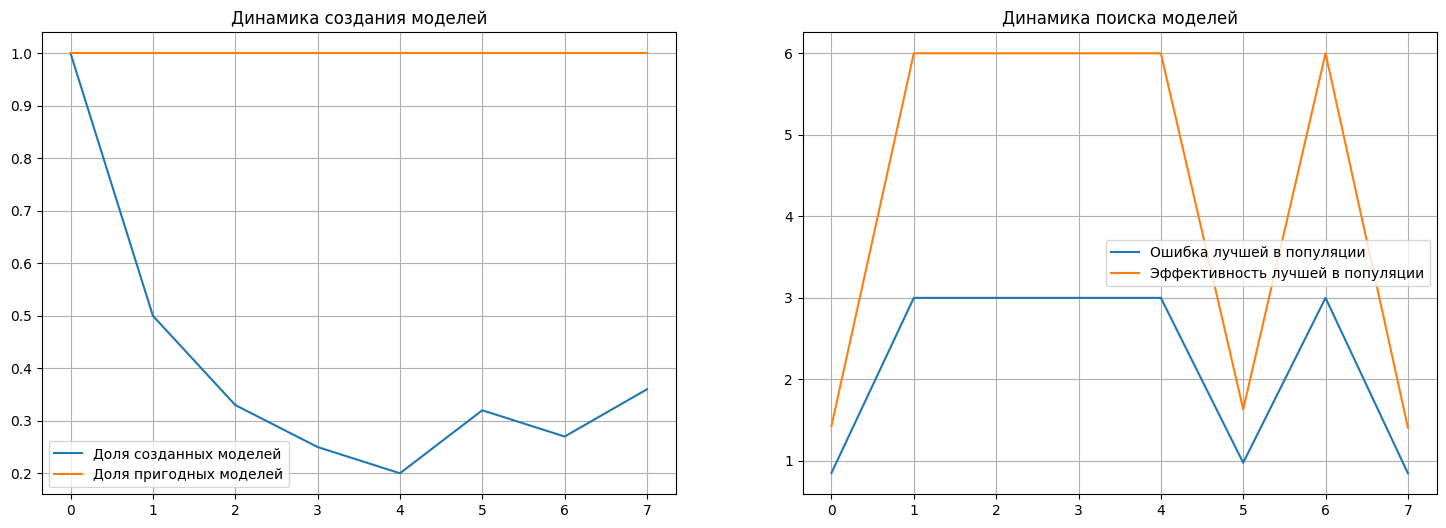


Проходимся по популяциям:  14%|█▍        | 1/7 [04:02<24:12, 242.03s/popul]

Мегапопуляция 0, эпоха 2
Модели популяции: создано [29, 0.36] брак [51, 0.64]
Модели популяции: пригодны [29, 1.0] не пригодны [0, 0.0]
Recur - создалась
Recur - подошла под задачу
Оценка модели 16.982766552335136 и время 4.872577142715454
Recur - создалась
Recur - подошла под задачу
Оценка модели 12.678022661627592 и время 5.578582096099853

Recur - не создалась
Оценка модели 1000 и время 1000
Recur - создалась
Recur - подошла под задачу
Оценка модели 13.586434932585398 и время 5.810967826843262
Recur - создалась


In [ ]:
import time
from tqdm import tqdm
warnings.filterwarnings("ignore")
EPOCH_VAL = 5
# ВЕРСИЯ КОДА С ПОСЕВОМ и генетикой в создании новых популяций

# Сохраняем массивы лучших моделей на диск
# [[[bot_pop_1],[blockov_list_1],[bot_1]],[[bot_pop_1],[blockov_list_1],[bot_1]]]
# куда  пишет данные этот код
directory = 'model/'

########### посев сетей вначале кода ############################################
posev = [] # смотри пояснения выше как передать сюда ранее созданные данные
# если еще нет список моделий, то ввести 0
# или можно вручную списки подать, указав вместо 0, сколько будкт сетей
# последовательно в ответ ввести  листы [bot_pop], [blockov_list], [bot]

# в текстовой ячейке ниже есть 2 сети для посева вручную

########### для подсевания лучших сетей прошлых эпох ###########################
waitnets = 3 # сколько выводим лучших для для изучения и посева
dw = 0.4 # доля лучших с прошлых эпох для подсева
frbest = 3 # как часто подсевыем лучших с прошлых эпох
################################################################################

########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = y_train.shape[1]

# функции активации для выходного слоя
activ_out = ['linear']
# словарь типов сетей
style_net = {0: 'Dense',
             1: 'Conv',
             2: 'Recur',
             None: 'MIX'
}

################################################################################
q_tyblocks = 8    # макс количество генерируемых блоков для сети
q_lays = 10       # макс количество слоев в блоках
################################################################################
verbouse = 0 # 0 - silent выводить или нет точность по ходу обучения
epohs = 10        # Количество эпох для поиска
################################################################################

################################################################################
n = 10            # количество ботов популяции
p = 7             # количество популяций

dn = 0.3 # доля выживших ботов
dp = 0.3 # доля выживших популяций

dneff = 0.1 # доля выживших ботовию по эффективности
dpeff = 0.1 # доля выживших популяций
            # по эффективности

prb_randbot = 0.2 # вероятность появления случайного бота в новой популяции
mutp = 0.4   # Коэфициент мутаций при создании мегабота новой популяции
mutn = 0.45  # Коэфициент мутаций при создании бота новой сети в популяции

dpsurv = 0.8 # доля от выживших ботов популяции используемыех в родителях
dnsurv = 0.8 # доля от выживших ботов мегапопуляции используемыех в родителях
################################################################################


################################################################################

nsurv = max(2,round(dn* n))  # Кол-во выживших ботов мин 2 для родителей
psurv = max(2,round(dp * p)) # Кол-во выживших популяций

nsurv_eff = max(1,round(dneff * n)) # Коли-во выживших ботов поп-ии по эффект.
psurv_eff = max(1,round(dpeff * p)) # Кол-во выживших ботов мегапоп по эффект.

nnew = max(0, n - nsurv - nsurv_eff)  # Кол-во новых ботов
pnew = max(0, p - psurv - psurv_eff)  # Кол-во новых популяций

parents_n = round(nsurv*dnsurv) # выж. боты популяции используемые в родителях
parents_p = round(psurv*dpsurv) # выж. боты мегапопуляции используемые в родит.

sevbest = round(waitnets*dw) # сколько подсеем лучших с прошлых эпох
################################################################################


################################################################################
popul = []         # обнулении популяции
val_p = []         # обнулении точности популяции
# создаем мегопопуляцию популяций ботов
mega_popul = []
mega_info = []
botpop_lst = []

start_time = time.time()

# для посева из определенных моделей нужно создвть лист сетей попримеру
# или ввести 0 при запросе input()
if posev == []: posev = posev_net()

for m in range(p):
############# ПОСЕВ ############################################################
    # сеем популяции из листа posev
    if posev != [] and m < len(posev):
        bot_pop = posev[m][0]
        blockov_list = posev[m][1]
        popul = []                 # Создаем пустую популяцию
        popul.append(posev[m][2])  # задаем первого бота популяции из сева
        for i in range(1,n):       # Проходим по всей длине популяции от 1
            # создаем оставшихся случайнонных ботов из сеяного blockov_list
            # определяем тип создания модели
            choosing_net = Set_net(bot_pop[2], activ_lays, activ_out, neiro_out)
            # инициализируем класс структуры блоков на основе парраметров сети
            maker_blocks = Make_blocks(choosing_net)
            bot = maker_blocks.buildblock_bot(blockov_list)
            popul.append(bot)      # добавляем бота в популяцию

################################################################################
    # генерируем бота популяции
    else: # если нет посева или если посев менее нужного количества
        # случайно выбираем тип популяции
        type_net = random.choice((None, 0, 1, 2))
        # инициализируем Set_net на основе заданных парамметров
        choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
        # инициализируем класс структуры блоков на основе парраметров сети
        maker_blocks = Make_blocks(choosing_net)
        bot_pop = maker_blocks.buildpopulbot(q_tyblocks, q_lays)

        # генерируем из состав блоков из к-ва блоков и слоев
        structure = [np.random.randint(0,bot_pop[1]) for i in range(bot_pop[0])]
        # создаем единый список блоков для популяции
        blockov_list = maker_blocks.sostav_blockov(structure)
        popul = []             # Создаем пустую популяцию
        for i in range(n):     # Проходим по всей длине популяции
            # создаем очередного случайнонного бота на основе blockov_list
            bot = maker_blocks.buildblock_bot(blockov_list)
            popul.append(bot)  # добавляем бота в популяцию

    mega_popul.append(popul) # доб. популяцию в мегапопуляцию
    mega_info.append(blockov_list) # доб. информацию о блоках  в мегапопуляцию
    botpop_lst.append(bot_pop) # доб. мегабота популяции в лист ботов популяций
if posev != []: print(f'Посеено {len(posev)} сетей')

# счетчики
avl_mdl = 0 # счетчик созданных моделей
non_mdl = 0 # счетчик не созданных моделей
ntk_mdl = 0 # счетчик моделей не подходящих под задачу
gd_mdl  = 0 # счетчик моделей пригодных под задачу
################################################################################

################################################################################
# для сбора данных об эффективности обучения от эпохи
ephtime_lst = []
avlmdl_lst  = []
gdmdl_lst   = []
sval_lst    = []
seff_lst    = []
svalp_lst   = []
seffp_lst   = []
bestnets = []
val_best = []
################################################################################

# Пробегаемся по всем эпохам
for it in tqdm(range(epohs), unit ="epohs",  # Пробегаемся по всем эпохам
                   desc ="Пробегаемся по всем эпохам"):
    val_p = []
    eff_p = []
    curr_time = time.time()
    for m in tqdm(range(p), unit ="popul",
                desc ="Проходимся по популяциям/n/r"): # проходимся по популяциям
        popul = mega_popul[m]       # берем очередную популяцию
        blockov_list = mega_info[m] # берем информацию и популяции
        bot_pop = botpop_lst[m]     # берем очередного мегабота популяцию
        val = []
        eff = [] #  список для списков по среднему обучению модели в fit()
        for i in range(n): # Проходим по всей длине популяции
            bot = popul[i] # Берем очередного бота

            ########################################
            # определяем тип создания модели
            choosing_net = Set_net(bot_pop[2], activ_lays, activ_out, neiro_out)
            # инициализируем класс структуры блоков на основе парраметров сети
            maker_blocks = Make_blocks(choosing_net)
            # инициализируем класс формирования сети
            regress_model = WildregressModel(INSHAPE)
            # тип сети для отображения
            discription = style_net[bot_pop[2]]
            ###########################################

           #####################################################################
           #               ОЦЕНКА МОДЕЛИ ОТ БОТА ПОПУЛЯЦИИ                     #
           #####################################################################
            try:
              # пробуем создать модель
              gen_model = regress_model(bot_pop,      # бот_популяции сетей
                                        bot,          # бот парам-в слоев сети
                                        blockov_list, # список имен слоев сети
                                        maker_blocks # класс построения блоков
                                         )
              # если превысили время, то gen_model - просто сообщение
              if type(gen_model) == str:
                  print(gen_model)
                  testing = False
              else: # значит модель создалась
                  print(discription + ' - создалась')
                  testing = True
                  avl_mdl+=1

              # Вычисляем точность текущего бота
              try:
                  if testing:
                      # оптимизатор
                      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
                      # функция потерь
                      loss = tf.keras.losses.MSE
                      # оценка по времени и смешанной точности нашей модели
                      result = evaluate_model(
                      # собственные парамметры функции
                      model = gen_model,           # тестируемая модель
                      y_scaler = Y_SCAILER,        # обученный скейлер для y
                      train_gen = train_datagen,   # генератор данных для обучения
                      val_gen = val_datagen,       # генератор данных для проверки
                      ep = EPOCH_VAL,                      # эпох обучения
                      verb = verbouse,             # отображать ли обучение
                      optimizer = optimizer,       # оптимизатор
                      loss = loss,                 # функция потерь
                      channels = np.arange(PREDICT_LAG),# Отображение сводки модели
                      predict_lag = PREDICT_LAG)   # На сколько шагов предсказание

                      # выводим результат оценки
                      # если превысили время, то gen_model - просто сообщение
                      if type(result) == str:
                        print(result)
                        ntk_mdl+=1
                        f = 500
                        tlrn = 500
                      else: # значит модель протестировалась
                        f = result[0]
                        tlrn = result[1]
                        print(discription + ' - подошла под задачу')
                        gd_mdl+=1

                  else:
                    print(discription + ' - слишком долго создавалась')
                    ntk_mdl+=1
                    f = 600
                    tlrn = 600


              except Exception:
              # если не создалась то пишем плохую точность
                  print(discription + ' - не подошла под задачу')
                  ntk_mdl+=1
                  f = 800
                  lrn = 800

            except Exception:
                # если не создалась то пишем плохую точность
              print(discription + ' - не создалась')
              non_mdl+=1
              f = 1000
              tlrn = 1000

            print(f'Оценка модели {f} и время {tlrn}')

            val.append(f)       # Добавляем полученное значение в список val
            eff.append(tlrn*f) # сохраняем время эффективность обучения модели
           #####################################################################

        ########################################################################
        # Сортируем val
        sval = sorted(val, reverse=0)
        val_p.append(sval)
        #для сбора динамики точности от популяции
        sval_lst.append(np.log10(sval[0]))

        # Сортируем по эффективности
        seff = sorted(eff, reverse=0)
        eff_p.append(seff)
        # для сбора динамики эффективности от популяции
        seff_lst.append(np.log10(seff[0]))
        ########################################################################

        clear_output()
        ########################################################################
        # сбор|вывод данных эффективности поиска от популяции к популяции
        try:
            avlmdl = round(avl_mdl/(avl_mdl+non_mdl),2)
            avlmdl_lst.append(avlmdl)
            nonmdl = round(non_mdl/(avl_mdl+non_mdl),2)
            gdmdl = round(gd_mdl/(avl_mdl),2)
            gdmdl_lst.append(gdmdl)
            ntkmdl = round(ntk_mdl/(avl_mdl),2)
            # Показываем ход генитеческого поиска
            show_pocess_1(avlmdl_lst, gdmdl_lst, sval_lst, seff_lst)
            print(f'Мегапопуляция {m}, эпоха {it+1}')
            print(f'Модели популяции: создано {[avl_mdl,avlmdl]} брак {[non_mdl,nonmdl]}')
            print(f'Модели популяции: пригодны {[gd_mdl,gdmdl]} не пригодны {[ntk_mdl,ntkmdl]}')
        except:
            pass

    ############################################################################
    # сбор и вывод данных для оценки эффективности поиска от эпохи
    # сорт. список точностей мегапопуляции отсортированые точностями популяций
    sval_p = sorted(val_p, key=lambda x: x[0])
    # сортируем список точностей мегапопуляции по эффективности
    seff_p = sorted(eff_p, key=lambda x: x[0])
    eph_time = time.time() - curr_time
    # собираем для контроля поиска и отображения
    svalp_lst.append(np.log10(sval_p[0][0]))
    seffp_lst.append(np.log10(seff_p[0][0]))
    ephtime_lst.append(eph_time)

    ############################################################################
    # Показываем ход генитеческого поиска
    if it > 1: show_process_2(svalp_lst, seffp_lst, ephtime_lst)

    # Показыааем результаты лучших ботов
    acc_models = np.array(sval_p)[:4,:4]
    eff_models = np.array(seff_p)[:4,:4]
    to_end = round(np.mean(ephtime_lst)*(epohs-it-1))
    print(f'Эпоха {it}, точность моделей {acc_models}')
    print(f'Время на эпоху {eph_time}, эффективность моделей {eff_models}')
    print(f'До окончания поиска {to_end} сек.')
    ############################################################################

    ########## пересохраняем каждую эпоху данные ###############################
    saver([mega_popul, botpop_lst, mega_info, svalp_lst, ephtime_lst], directory)
    # это можно взять в свернутый лист автопосев на случай сбоя колаба
    # то возобновить код с момента создания новых мега популяций и популяций
    ############################################################################

    ############################################################################
    #   ФОРМИРОВАНИЕ НОВЫХ ПОПУЛЯЦИЙ НА ОСНОВЕ ПОЛУЧЕННЫХ ОЦЕНОК               #
    ############################################################################
    newmega_popul = []
    newmega_info  = []
    newbotpop_lst = []
    newtime_mega  = []
    # записываем данные лучших по точночти сетей
    for m in range(psurv): # проходимся по выжившим мега-популяциям
        idx_p = val_p.index(sval_p[m])  # индекс из списка лучших
        newmega_popul.append(mega_popul[idx_p])
        newmega_info.append(mega_info[idx_p])
        newbotpop_lst.append(botpop_lst[idx_p])

    # записываем эффективных  ботов популяций
    for m in range(psurv_eff): #
        idx_p = eff_p.index(seff_p[m])  # индекс из списка эффективных
        newmega_popul.append(mega_popul[idx_p])
        newmega_info.append(mega_info[idx_p])
        newbotpop_lst.append(botpop_lst[idx_p])

    # идем по отобранным популяциям точных и эффективных
    for m in range(psurv+psurv_eff):
        newpopul = []
        newtime_pop= []
        popul = newmega_popul[m]
        blockov_list = newmega_info[m]
        bot_pop = newbotpop_lst[m]

        # записываем отобранных ботов в популяции
        for i in range(nsurv):
            idx = val.index(sval[i])  # индекс бота лучших в списке val
            newpopul.append(popul[idx])
        # записываем эффективных ботов в популяци
        for i in range(nsurv_eff):
            idx = eff.index(seff[i]) # индекс бота эффекивных в списке val
            newpopul.append(popul[idx])

        # берем ген определяющий тип сети популяции
        type_net = bot_pop[2]
        choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
        ## инициализируем класс структуры блоков на основе параметров сети
        maker_blocks = Make_blocks(choosing_net)
        bots_random = [maker_blocks.buildblock_bot(blockov_list) \
                       for i in range(nnew)]
        # Проходимся в цикле nnew-раз
        for i in range(nnew):
            idxp =  np.random.randint(0, nsurv + nsurv_eff, parents_n)
            bots_parent = [newpopul[i] for i in idxp]

            newbot = []  # Создаем пустой список под значения нового бота
            # Пробегаем по всей длине бота
            for j in range(len(blockov_list)):
              k = np.random.randint(0, parents_n)
              x = bots_parent[k][j]

              # С вероятностью mutn устанавливаем значение бота
              if (np.random.random() < mutn):
                k = np.random.randint(0, nnew)
                x = bots_random[k][j]

              newbot.append(x)      # Доб. очередное значение в нового бота
            newpopul.append(newbot) # Доб. бота в новую популяцию
        # Собираем популяцию
        popul = newpopul
        newmega_popul.append(popul)
        newmega_info.append(blockov_list)
        newbotpop_lst.append(bot_pop)

        ########## пересохраняем каждую эпоху данные ###########################
        saver([newmega_popul, newbotpop_lst, newmega_info], directory)
        # это можно взять в свернутый лист автопосев на случай сбоя колаба
        # то возобновить код с момента создания новых мега популяций и популяций
        ########################################################################

    ##################### ПОДСКАЗКА ДЛЯ УЛУЧШЕНИЯ ##############################
    # Можно тут организовать тригер, чтобы имея сохраненными newmega_popul,
    # newbotpop_lst, newmega_info на диске, запускать цихл не вначале, а с этого
    # момента, загрузив вначале их в код.
    ############################################################################

    ########### Сортировка и сохранение лушх сетей #############################
    # получаем индексы  лучших сетей по всем мегапопуляциям
    idxs, sval_best = get_idxbest(sval_p, waitnets)
    # получаем спиок лучших сетей по всем мегапопуляциям на эпохе
    newbestnets = get_bestnets(idxs, newbotpop_lst, newmega_info, newmega_popul)
    for i in range(waitnets):
        bestnets.append(newbestnets[i])
    # объединяем списки
    val_best = np.hstack((val_best,sval_best))
    idx = np.argsort(val_best)[:waitnets] # получаем индексы для сортировки
    val_best = val_best[idx]
    bestnets = [bestnets[i] for i in idx]
    np.save(directory + 'bestnets.npy', bestnets)
    ############################################################################

    ############# ПОДСЕВ лучшх сетей с прошлых эпох ############################
    if (it > 1 and  it % frbest == 0) and (p - psurv - psurv_eff - sevbest) > 0:
        pbest = sevbest
        posev_lst = bestnets[:pbest]
        # сеем популяции из листа posev
        for m in range(pbest):
            bot_pop = posev_lst[m][0]
            blockov_list = posev_lst[m][1]
            popul = []                 # Создаем пустую популяцию
            # задаем первого бота популяции из сева
            popul.append(posev_lst[m][2])
            # Проходим по всей длине популяции от 1
            for i in range(1,n):
                # берем ген определяющий тип сети популяции
                type_net = bot_pop[2]
                choosing_net = Set_net(type_net, activ_lays, activ_out,
                                       neiro_out)
                # иници/ класс структуры блоков на основе парраметров сети
                maker_blocks = Make_blocks(choosing_net)
                # создаем оставшихся случайнонных ботов из сеяного blockov_list
                bot = maker_blocks.buildblock_bot(blockov_list)
                popul.append(bot)      # добавляем бота в популяцию
            # добавляем популяцию в мегапопуляцию
            newmega_popul.append(popul)
            # добавляем информацию о блоках  в мегапопуляцию
            newmega_info.append(blockov_list)
            # добавляем мегабота популяции в лист ботов популяций
            newbotpop_lst.append(bot_pop)
        print(f'Посеено {len(posev_lst)} сетей из лучших прошлых эпох')
    else:
        pbest = 0

    ############################################################################
    #     создаем новых ботов новых популяций основе скрещиваний и мутаций     #
    ############################################################################
    pneweph = pnew - pbest # сколько  создаем новых популяций от родителей
    # случайно выбираем тип сети
    type_net = random.choice((None, 0, 1, 2))
    # создаем новых ботов в эту популяцию
    choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
    # инициализируем класс структуры блоков на основе парраметров сети
    maker_blocks = Make_blocks(choosing_net)
    bots_poprandom = [maker_blocks.buildpopulbot(q_tyblocks, q_lays) \
                      for i in range(pnew - pbest)]
    # создаем популяции от родителей
    for m in range(pneweph):
        idxp =  np.random.randint(0, psurv + psurv_eff, parents_p)
        bots_popparent = [newbotpop_lst[i] for i in idxp]
        # Создаем пустой список под значения нового мегабота
        newbot_pop = []
        # Получаем случайное число в диапазоне от 0 до 1
        if np.random.random() < prb_randbot:
            k = np.random.randint(0, pneweph)
            bot_pop = bots_poprandom[k]  # берем совсем случайный бот пупуляции

        else:  # создаем бот пупуляции генетикой
            # Пробегаем по всей длине бота
            for j in range(len(bots_poprandom[0])):
                  k = np.random.random_integers(0, parents_p-1)
                  x = bots_popparent[k][j]

                  # С вер. mutp ставим значение бота из случайного мегабота
                  if np.random.random() < mutp:
                      k = np.random.randint(0, pneweph)
                      x = bots_poprandom[k][j]
                  newbot_pop.append(x)  # Доб. ген в нового мегабота
            bot_pop = newbot_pop        # бот популяции создан

        # генерируем из состав блоков популяции
        structure  = [np.random.randint(0, bot_pop[1]) for i in \
                      range(bot_pop[0])]
        # случайно выбираем тип сети
        type_net = random.choice((None, 0, 1, 2))
        choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
        # инициализируем класс структуры блоков на основе парраметров сети
        maker_blocks = Make_blocks(choosing_net)
        # создаем единый список блоков для популяции
        blockov_list = maker_blocks.sostav_blockov(structure)

        popul = [] # Создаем пустую популяцию
        # Проходим по всей длине популяции
        for i in range(n):
            # создаем очередного случайнонного бота на основе blockov_list
            bot = maker_blocks.buildblock_bot(blockov_list)
            popul.append(bot)  # доб. бота в популяцию
        newmega_popul.append(popul) # доб. популяцию в мегапопуляцию
        newmega_info.append(blockov_list) # доб. информацию о блоках
        newbotpop_lst.append(bot_pop) # доб. мегабота

    # перезаписываем информацию
    mega_popul = newmega_popul
    mega_info = newmega_info
    botpop_lst = newbotpop_lst
    ############################

    ########## пересохраняем каждую эпоху данные ###############################
    saver([mega_popul, botpop_lst, mega_info, svalp_lst], directory)
    # это можно взять в свернутый лист автопосев на случай сбоя колаба
    # то возобновить код с момента создания новых мега популяций и популяций
    ############################################################################

finish_time = time.time() - start_time
print(f'\n\rОбщее время подбора за {epohs} эпох по {p*n} моделей составило {finish_time}')

# ПРИМЕР ДЛЯ ПОСЕВА ВРУЧНУЮ:

In [ ]:
# вариант из презентации
bot_pop = [7, 1, None, 1, 16, 7, 0, 0, 0, 0]
setblockov = [[], [], ['Conv1DT'], ['Dense'], [], [], []]
bot = [[], [], [64, 4], [128], [], [], []]

# иной вариант
bot_pop = [4, 1, None, 1, 128, 6, 0, 0, 0, 0]
setblockov = [[], ['Lstm'], ['Conv1D_dilation_block'], []]
bot = [[], [4], [8, 2], []]

# После генетики

# Генерация нейронки

In [ ]:
directory = '..папка куда сохранял ваш код выше../'  # куда пишет данные код
########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = y_train.shape[1]

# функции активации для выходного слоя
activ_out = ['linear']

# загружаем список парамметров лучших сетей
save_nets = np.load(directory+'bestnets.npy', allow_pickle = True)

# генерируем список моделей в количестве n
set_models = getnetfrombest(save_nets, activ_lays,
                            activ_out, neiro_out,
                            limit = TIMELIMIT_1,
                            n = 3)

In [ ]:
k = 0 # указываем индекс от 0 до n-1 для выбора модели
good_model = set_models[k]
good_model.call = tf.function(good_model.call)

# Отображение сводки модели
good_model.summary()

In [ ]:
# дерево модели
tf.keras.utils.plot_model(good_model, show_shapes=True)

# Обучение сгенерированной модели

In [ ]:
from time import time
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

# очистка ОЗУ
clear_ozu = GarbageCollectorCallback()

# Вариант 1 - Базавое как в лекции

In [ ]:
# оптимизатор
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.Huber() # MSE #
good_model.compile(optimizer = optimizer, loss = loss)

# понижение шага
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8,
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=17,
    mode='min',
    restore_best_weights=True)

In [ ]:
start = time()
# обучение модели вашей
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 150,
                          callbacks=[early_stopping, reduce_lr, clear_ozu],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

# Вариант 2 - используя CyclicalLearningRate и SGD

In [ ]:
# дополнительная библиотека tensorflow_addons
#!pip install -q -U tensorflow_addons

import tensorflow_addons as tfa

In [ ]:
INIT_LR = 1e-3
MAX_LR = 1e-2

steps_per_epoch = len(x_train) // BATCH_SIZE

# понижение шага циклами
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
# оптимизатор
optimizer = tf.keras.optimizers.SGD(clr)

# функция потерь
loss = tf.keras.losses.Huber() #MSE #
good_model.compile(optimizer = optimizer, loss = loss)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience= 55,
    mode='min',
    restore_best_weights=True)

In [ ]:
start = time()
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 150,
                          callbacks=[early_stopping, clear_ozu],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

# Вариант 3 - используя взвешанное MSE
пример https://towardsdatascience.com/how-to-create-a-custom-loss-function-keras-3a89156ec69b

In [ ]:
len_period = PREDICT_LAG

weights = []
for i in range(len_period):
  w = (len_period-i)/len_period
  weights.append(w)

weights

In [ ]:
def weight_mse(w):

    def custom_mse(y_true, y_pred, w = w):
        # разница target и predicted
        loss = tf.keras.backend.square(y_pred - y_true)  # (batch_size, 2)

        # умножаем на веса
        loss*= w         # (batch_size, 2)

        # усредняем ошибку
        loss = tf.keras.backend.mean(loss, axis=-1)        # (batch_size,)
        return loss
    return custom_mse

In [ ]:
import tensorflow_addons as tfa
INIT_LR = 1e-4
MAX_LR = 1e-3

steps_per_epoch = len(x_train) // BATCH_SIZE

# понижение шага циклами
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
# оптимизатор
optimizer = tf.keras.optimizers.SGD(clr)
# функция потерь
loss = weight_mse(weights)
good_model.compile(optimizer = optimizer, loss = loss)

# понижение шага
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8,
                                                 patience = 3,
                                                 min_lr = 1e-9, verbose = 1)
# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience= 55,
    mode='min',
    restore_best_weights=True)

In [ ]:
start = time()
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 200,
                          callbacks=[early_stopping, clear_ozu],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

In [ ]:
plt.plot(history.history['loss'],
         label='MSE ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='MSE на проверочном наборе')
plt.ylabel('MSE ошибка')
plt.legend()
plt.show()

# Оценка модели на VAL данных

In [ ]:
# Прогнозируем данные текущей сетью
(y_pred_val, y_true_val) = get_scalepred(good_model, XVAL, YVAL, Y_SCAILER) #Прогнозируем данные

# Отображаем графики
show_predict(0,                    # начало периода
             y_true_val.shape[0],  # конец периода
             [4],                  # по предсказанию на какие шаги отрисовываем
             y_pred_val,           # предчказанные цены
             y_true_val,           # реальные цены
             PRED_PRICE,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([4],             # по предсказанию на какие шаги отрисовываем корреляцию
          50,     # на сколько шагов предсказание
          y_pred_val,      # предчказанные цены
          y_true_val       # реальные цены
          )